In [1]:
import numpy as np
import pandas as pd
import time as t
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from datetime import *
from collections import Counter
import json
from scipy.stats import percentileofscore, rankdata
import itertools

In [3]:
def filter_g_k_one(data,k=10,u_name='user_id',i_name='business_id',y_name='stars'):
    item_group = data.groupby(i_name).agg({y_name:'count'})
    item_g10 = item_group[item_group[y_name]>=k].index
    data_new = data[data[i_name].isin(item_g10)]
    user_group = data_new.groupby(u_name).agg({y_name:'count'})
    user_g10 = user_group[user_group[y_name]>=k].index
    data_new = data_new[data_new[u_name].isin(user_g10)]
    return data_new

def filter_tot(data,k=10,u_name='user_id',i_name='business_id',y_name='stars'):
    data_new=data
    while True:
        data_new = filter_g_k_one(data_new,k=k,u_name=u_name,i_name=i_name,y_name=y_name)
        m1 = data_new.groupby(i_name).agg({y_name:'count'})
        m2 = data_new.groupby(u_name).agg({y_name:'count'})
        num1 = m1[y_name].min()
        num2 = m2[y_name].min()
        print('item min:',num1,'user min:',num2)
        if num1>=k and num2>=k:
            break
    return data_new

### Movielens

In [336]:
ml = pd.read_csv('ml/ml1m/ratings.dat', sep='::', header=None)
ml.columns = ["user", "item", "rate", "time"]

/tmp/ipykernel_1166412/1827676945.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ml = pd.read_csv('ml/ml1m/ratings.dat', sep='::', header=None)


In [337]:
print(ml.shape)
ml = filter_tot(ml,k=10,u_name='user',i_name='item',y_name='rate')
print(ml.shape)

(1000209, 4)
item min: 10 user min: 17
(998539, 4)


In [338]:
ml.to_csv('ml/ml1m/ratings.csv', index=False)
ml['time2'] = ml.time.apply(lambda x: datetime.fromtimestamp(x))

In [339]:
ml['time3'] = ml.time2.dt.year*10000 + ml.time2.dt.month*100 + ml.time2.dt.day

In [340]:
var_map = dict(zip(sorted(ml['time3'].unique()), range(len(ml['time3'].unique()))))
ml['time4'] = ml['time3'].apply(lambda x: var_map[x])

In [193]:
items = sorted(ml.item.unique())
prev = 0
totaldf = pd.DataFrame(columns=["time", "item", "perc"])
for i, t in enumerate(sorted(ml.time3)):
    temp = ml[ml.time3 == t]
    counter = list(Counter(temp.item).values())
    percs = [percentileofscore(counter, v) for v in counter]
    item_orders = list(counter.keys())
    left = list(set(items) - set(item_orders))
    df = pd.DataFrame({"time": [i for _ in range(len(items))], "item": item_orders + left, "perc": percs + list(np.zeros(len(left)))})
    totaldf = pd.concat([totaldf, df])
#     prev = t

KeyboardInterrupt: 

In [95]:
totaldf.to_csv('ml/ml1m/pop_month.csv', index=False)

In [98]:
ml = pd.read_csv('ml/ml1m/ratings.csv')
totaldf = pd.read_csv('ml/ml1m/pop.csv')

In [139]:
pfs = np.zeros((len(items), 5))
for i in items:
    pfs[i,:] = np.polyfit(range(100), totaldf[totaldf.item == i].perc, 4)

In [141]:
topitems = np.unique(totaldf.groupby("time").apply(pd.DataFrame.nlargest, n=10, columns='perc').reset_index(drop=True)['item'])

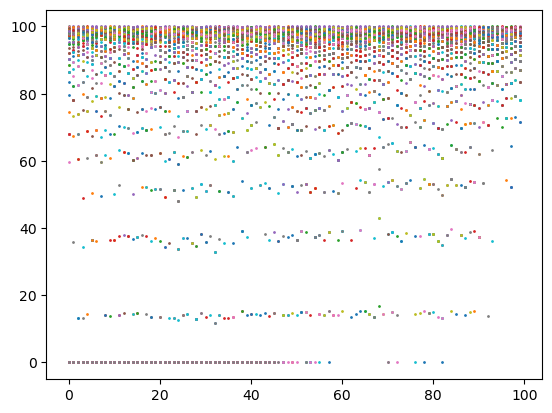

In [142]:
for i in topitems:
    plt.scatter(range(100), totaldf[totaldf.item == i].perc, s=1)

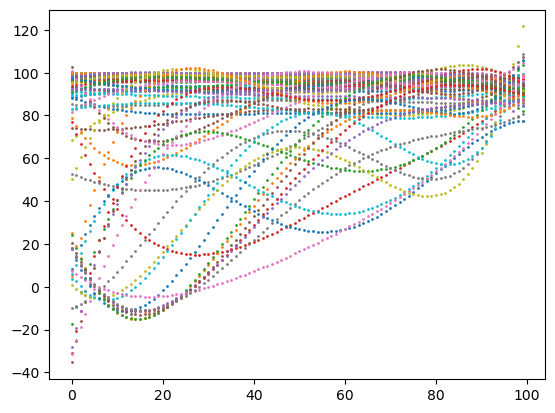

In [143]:
for i in topitems:
    plt.scatter(range(100), [j**4*pfs[i, 0] + j**3*pfs[i, 1] + j**2*pfs[i, 2] + j*pfs[i, 3] + pfs[i, 4] for j in range(100)], s=1)

In [341]:
uniqs = ml.groupby('user')['time4'].agg(np.ptp).values
upops = ml.groupby('user').apply(lambda x: len(x)).values

Text(0, 0.5, 'Days between')

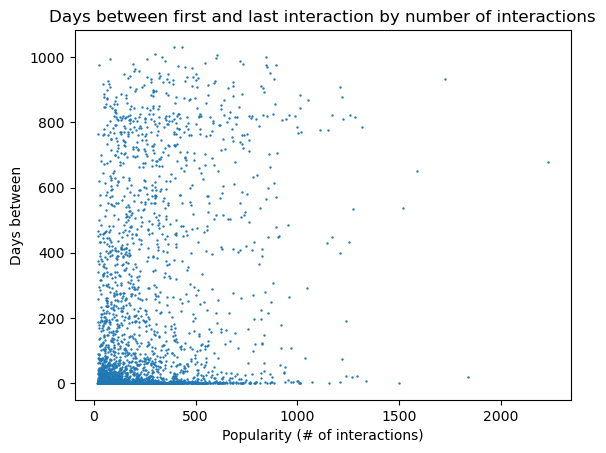

In [342]:
plt.scatter(upops, uniqs, s=0.5)
plt.title('Days between first and last interaction by number of interactions')
plt.xlabel('Popularity (# of interactions)')
plt.ylabel('Days between')

In [3]:
def pop_embed(perc):
    if perc == 0:
        return [0]*11
    loc = int(perc//10)
    if perc % 10 == 0:
        return [0]*loc + [1] + [0]*(10 - loc)
    return [0]*loc + [1 - (perc%10) / 10] + [(perc%10) / 10] + [0]*(9 - loc)

In [1]:
def pop_embed2(perc):
    if perc == 0:
        return [0]*6
    loc = int(perc//20)
    if perc % 20 == 0:
        return [0]*loc + [1] + [0]*(5 - loc)
    return [0]*loc + [1 - (perc%20) / 20] + [(perc%20) / 20] + [0]*(4 - loc)

### Amazon office

In [326]:
ao = pd.read_csv('amazon_office.csv', header=None)
ao.columns=["item", "user", "rate", "time"]

In [328]:
ao = filter_tot(ao,k=5,u_name='user',i_name='item',y_name='rate')

item min: 1 user min: 5
item min: 1 user min: 5
item min: 2 user min: 5
item min: 3 user min: 5
item min: 4 user min: 5
item min: 5 user min: 5


In [12]:
item_map = dict(zip(sorted(ao.item.unique()), range(len(ao.item.unique()))))
ao.item = ao.item.apply(lambda x: item_map[x])
user_map = dict(zip(sorted(ao.user.unique()), range(len(ao.user.unique()))))
ao.user = ao.user.apply(lambda x: user_map[x])

In [20]:
ao['time2'] = ao.time.apply(lambda x: datetime.fromtimestamp(x))
ao['time3'] = ao.time2.dt.year*10000 + ao.time2.dt.month*100 + ao.time2.dt.isocalendar().week
var_map = dict(zip(sorted(ao['time3'].unique()), range(len(ao['time3'].unique()))))
ao['time4'] = ao['time3'].apply(lambda x: var_map[x])

In [345]:
uniqs2 = ao.groupby('user')['time4'].agg(np.ptp).values
upops2 = ao.groupby('user').apply(lambda x: len(x)).values

Text(0, 0.5, 'Days between')

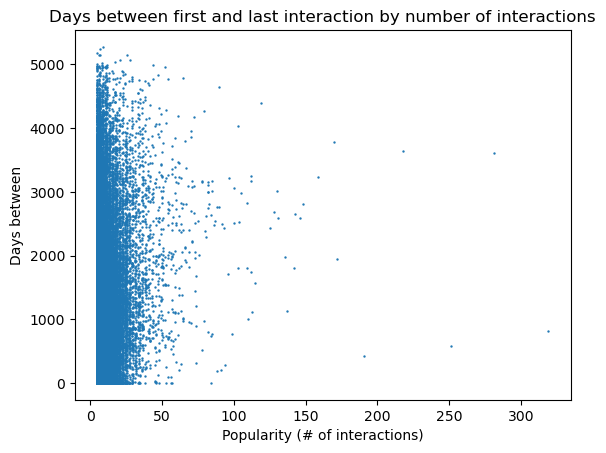

In [346]:
plt.scatter(upops2, uniqs2, s=0.5)
plt.title('Days between first and last interaction by number of interactions')
plt.xlabel('Popularity (# of interactions)')
plt.ylabel('Days between')

In [ ]:
items = sorted(ao.item.unique())
totaldf = pd.DataFrame(columns=["time", "item", "perc"])
grouped = ao.groupby('time4')
for i, ints in grouped:
    counter = Counter(ints.item)
    vals = list(counter.values())
    percs = [percentileofscore(vals, v) for v in vals]
    item_orders = list(counter.keys())
    left = list(set(items) - set(item_orders))
    df = pd.DataFrame({"time": [i for _ in range(len(items))], "item": item_orders + left, "perc": percs + list(np.zeros(len(left)))})
    totaldf2 = pd.concat([totaldf, df])

In [ ]:
totaldf.sort_values('time', inplace = True)
totaldf.to_csv("amazon_office_total.csv", index=False)

In [ ]:
percdict = totaldf.set_index(['time', 'item']).to_dict('index')

{(0, 543): {'perc': 100.0},
 (0, 18339): {'perc': 0.0},
 (0, 18338): {'perc': 0.0},
 (0, 18337): {'perc': 0.0},
 (0, 18336): {'perc': 0.0},
 (0, 18335): {'perc': 0.0},
 (0, 18334): {'perc': 0.0},
 (0, 18333): {'perc': 0.0},
 (0, 18332): {'perc': 0.0},
 (0, 18331): {'perc': 0.0},
 (0, 18330): {'perc': 0.0},
 (0, 18340): {'perc': 0.0},
 (0, 18329): {'perc': 0.0},
 (0, 18327): {'perc': 0.0},
 (0, 18326): {'perc': 0.0},
 (0, 18325): {'perc': 0.0},
 (0, 18324): {'perc': 0.0},
 (0, 18323): {'perc': 0.0},
 (0, 18322): {'perc': 0.0},
 (0, 18321): {'perc': 0.0},
 (0, 18320): {'perc': 0.0},
 (0, 18319): {'perc': 0.0},
 (0, 18318): {'perc': 0.0},
 (0, 18328): {'perc': 0.0},
 (0, 18341): {'perc': 0.0},
 (0, 18342): {'perc': 0.0},
 (0, 18343): {'perc': 0.0},
 (0, 18366): {'perc': 0.0},
 (0, 18365): {'perc': 0.0},
 (0, 18364): {'perc': 0.0},
 (0, 18363): {'perc': 0.0},
 (0, 18362): {'perc': 0.0},
 (0, 18361): {'perc': 0.0},
 (0, 18360): {'perc': 0.0},
 (0, 18359): {'perc': 0.0},
 (0, 18358): {'perc'

In [ ]:
ao['perc'] = ao.apply(lambda x: percdict[(x['time4'], x['item'])]['perc'], axis=1)

In [ ]:
ao.to_csv("amazon_office.csv", index=False)

In [2]:
totaldf = pd.read_csv("amazon/amazon_office_total.csv")

In [4]:
ao = pd.read_csv("amazon/amazon_office.csv", parse_dates = ['time2'])

In [34]:
pfs = np.zeros((len(items), 5))
grouped2 = totaldf.groupby('item')
numperiods = max(totaldf['time']) + 1
for i, itemgroup in grouped2:
    pfs[i,:] = np.polyfit(range(numperiods), itemgroup['perc'], 4)

In [64]:
pfits = np.zeros((len(items), numperiods))
for i in range(len(items)):
    pfits[i, :] = [j**4*pfs[i, 0] + j**3*pfs[i, 1] + j**2*pfs[i, 2] + j*pfs[i, 3] + pfs[i, 4] for j in range(numperiods)]

In [67]:
pact = totaldf.pivot(index='item', columns='time', values='perc').values

/tmp/ipykernel_394994/2368571898.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pact = totaldf.pivot(index='item', columns='time', values='perc')


In [80]:
np.sqrt(np.square(pfits - pact).sum()/(pact.size))

6.458158480884719

In [59]:
# topitems = np.unique(totaldf.groupby("time").apply(pd.DataFrame.nlargest, n=1, columns='perc').reset_index(drop=True)['item'])
topitems = totaldf.groupby("time").apply(pd.DataFrame.nlargest, n=1, columns='perc').reset_index(drop=True)['item']

Counter({543: 6,
         540: 1,
         596: 6,
         592: 4,
         601: 2,
         618: 5,
         589: 5,
         612: 2,
         294: 1,
         567: 2,
         558: 1,
         611: 4,
         645: 4,
         609: 3,
         610: 2,
         607: 2,
         649: 5,
         2184: 1,
         651: 2,
         654: 7,
         537: 1,
         595: 2,
         650: 3,
         655: 6,
         535: 1,
         566: 3,
         644: 3,
         561: 1,
         593: 2,
         752: 3,
         761: 2,
         562: 1,
         621: 2,
         770: 3,
         615: 2,
         783: 3,
         811: 2,
         769: 2,
         806: 2,
         799: 2,
         576: 1,
         551: 4,
         548: 4,
         813: 1,
         802: 1,
         800: 3,
         835: 1,
         833: 4,
         834: 2,
         836: 2,
         839: 3,
         756: 3,
         3860: 1,
         859: 2,
         552: 1,
         873: 1,
         554: 1,
         572: 2,
         639

In [60]:
counter = Counter(topitems)
topitems2 = [key for key, value in counter.items() if value >= 5]

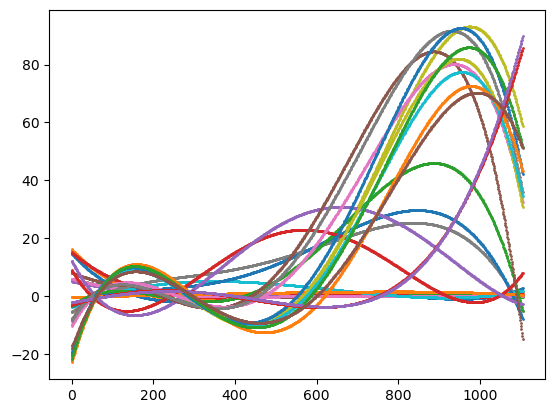

In [81]:
for i in topitems2:
    plt.scatter(range(numperiods), pfits[i, :], s=1)
#     plt.scatter(range(numperiods), totaldf[totaldf.item == i].perc, s=2)

In [12]:
ao.to_csv("amazon_office.csv", index=False)

In [4]:
ao = pd.read_csv("amazon/amazon_office.csv")

In [37]:
ao['timem'] = ao.time2.dt.year*100 + ao.time2.dt.month
var_map = dict(zip(sorted(ao['timem'].unique()), range(len(ao['timem'].unique()))))
ao['timemint'] = ao['timem'].apply(lambda x: var_map[x])

In [40]:
itemgroup = ao.groupby('item')
trendf = pd.DataFrame(columns=["timemint", "item", "trend1", "trend2"])
for i, group in itemgroup:
    counter = sorted(Counter(group['timemint']).items())
    cs = np.array([c[1] for c in counter])
    df = pd.DataFrame({"timemint": [c[0] for c in counter], "item": [i]*len(counter), "trend1": cs/np.cumsum(cs), "trend2": cs/np.sum(cs)})
    trendf = pd.concat([trendf, df])

In [41]:
percdict2 = trendf.set_index(['timemint', 'item']).to_dict('index')
ao['trend1'] = ao.apply(lambda x: percdict2[(x['timemint'], x['item'])]['trend1'], axis=1)
ao['trend2'] = ao.apply(lambda x: percdict2[(x['timemint'], x['item'])]['trend2'], axis=1)

In [51]:
np.percentile(ao.groupby('item').apply(lambda x: len(x)), 99.9)

1023.0320000001229

In [59]:
usergroup = ao[ao.user.isin(range(5))].groupby('user') # .filter(lambda x: np.random.rand() < 0.0001).groupby('user')

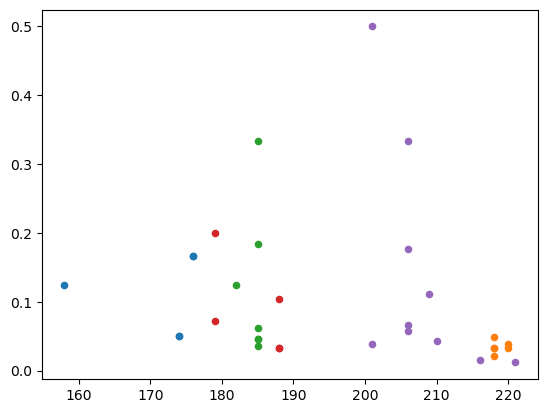

In [63]:
for _, group in usergroup:
    plt.scatter(group['timemint'], group['trend1'], s=20)

In [7]:
ao = pd.read_csv("amazon/amazon_office.csv", parse_dates = ['time2']).drop(['time', 'time3', 'time4', 'perc'], axis=1)

In [13]:
ao['time3'] = ao.time2.dt.year*10000 + ao.time2.dt.month*100
var_map = dict(zip(sorted(ao['time3'].unique()), range(len(ao['time3'].unique()))))
ao['time4'] = ao['time3'].apply(lambda x: var_map[x])

In [14]:
items = sorted(ao.item.unique())
grouped = ao.groupby('time4')
ototaldft = pd.DataFrame(columns=["time4", "item", "perc"])
counter = Counter()
for i, ints in grouped:
    counter.update(ints.item)
    vals = list(counter.values())
    percs = 100 * rankdata(vals, "average") / len(vals)
    item_orders = list(counter.keys())
    left = list(set(items) - set(item_orders))
    df = pd.DataFrame({"time4": [i for _ in range(len(items))], "item": item_orders + left, "perc": np.concatenate((percs, np.zeros(len(left))))})
    ototaldft = pd.concat([ototaldft, df])
    
ototaldft2 = pd.DataFrame(columns=["time4", "item", "perc"])
counter = Counter()
for i, ints in grouped:
    counter.update(ints.item)
    vals = list(counter.values())
    percs = 100 * rankdata(vals, "average") / len(vals)
    item_orders = list(counter.keys())
    left = list(set(items) - set(item_orders))
    df = pd.DataFrame({"time4": [i for _ in range(len(items))], "item": item_orders + left, "perc": np.concatenate((percs, np.zeros(len(left))))})
    ototaldft2 = pd.concat([ototaldft2, df])
    
ototaldft3 = pd.DataFrame(columns=["time4", "item", "perc"])
counter = Counter()
for i, ints in grouped:
    counter = Counter({k:0.5*v for k,v in counter.items()})
    counter.update(ints.item)
    vals = list(counter.values())
    percs = 100 * rankdata(vals, "average") / len(vals)
    item_orders = list(counter.keys())
    left = list(set(items) - set(item_orders))
    df = pd.DataFrame({"time4": [i for _ in range(len(items))], "item": item_orders + left, "perc": np.concatenate((percs, np.zeros(len(left))))})
    ototaldft3 = pd.concat([ototaldft3, df])

In [15]:
ototaldft.to_csv("amazon/amazon_office_currpop.csv", index=False)
ototaldft2.to_csv("amazon/amazon_office_cumpop.csv", index=False)
ototaldft3.to_csv("amazon/amazon_office_wtpop.csv", index=False)

In [18]:
otmp = ototaldft.pivot(index = 'time4', columns = 'item', values='perc')
otmp_ = otmp.apply(lambda x: [0]*121 + list(itertools.chain.from_iterable([pop_embed(p) for p in x])))
otmp2 = ototaldft2.pivot(index = 'time4', columns = 'item', values='perc')
otmp2_ = otmp2.apply(lambda x: [0]*121 + list(itertools.chain.from_iterable([pop_embed(p) for p in x])))
otmp3 = ototaldft3.pivot(index = 'time4', columns = 'item', values='perc')
otmp3_ = otmp3.apply(lambda x: [0]*121 + list(itertools.chain.from_iterable([pop_embed(p) for p in x])))

/tmp/ipykernel_1270798/2634951916.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  otmp = ototaldft.pivot(index = 'time4', columns = 'item', values='perc')
/tmp/ipykernel_1270798/2634951916.py:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  otmp2 = ototaldft2.pivot(index = 'time4', columns = 'item', values='perc')
/tmp/ipykernel_1270798/2634951916.py:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  otmp3 = ototaldft3.pivot(index = 'time4', columns = 'item', values='perc')


In [19]:
otmp_.to_csv("amazon/amazon_office_currembed.csv", index=False, mode='a', chunksize=250)
otmp2_.to_csv("amazon/amazon_office_cumembed.csv", index=False, mode='a', chunksize=250)
otmp3_.to_csv("amazon/amazon_office_wtembed.csv", index=False, mode='a', chunksize=250)

In [49]:
ao.sort_values(['time2'])[['user', 'item', 'time4', 'time6']].to_csv('amazon/amazon_office_int.csv', header=False, index=False)

In [ ]:
ao = pd.read_csv("amazon/amazon_office.csv", parse_dates = ['time2'])

In [ ]:
items = sorted(ao.item.unique())
ototaldftw = pd.DataFrame(columns=["time6", "item", "perc"])
grouped = ao.groupby('time4')
counter = Counter()
for i, ints in grouped:
    if i >= 4:
        counter.subtract(prev4)
    counter.update(ints.item)
    vals = list(counter.values())
    percs = 100 * rankdata(vals, "average") / len(vals)
    item_orders = list(counter.keys())
    left = list(set(items) - set(item_orders))
    df = pd.DataFrame({"time6": [i for _ in range(len(items))], "item": item_orders + left, "perc": np.concatenate((percs, np.zeros(len(left))))})
    ototaldftw = pd.concat([ototaldftw, df])
    if i >= 3:
        prev4 = prev3
    if i >= 2:
        prev3 = prev2
    if i >= 1:
        prev2 = prev1
    prev1 = ints.item
    if i % 50 == 0:
        print(i)

In [ ]:
ototaldftw.to_csv("amazon/amazon_office_weekpop.csv", index=False)
otmpw = ototaldftw.pivot(index = 'time6', columns = 'item', values='perc')
otmpw_ = otmpw.apply(lambda x: [0]*11 + list(itertools.chain.from_iterable([pop_embed(p) for p in x])))
otmpw_.to_csv("amazon/amazon_office_week_embed.csv", index=False, mode='a', chunksize=1000)

In [3]:
ototaldftw = pd.read_csv("amazon/amazon_office_weekpop.csv")
otmpw = ototaldftw.pivot(index = 'time6', columns = 'item', values='perc')
otmpw_ = otmpw.apply(lambda x: [0]*6 + list(itertools.chain.from_iterable([pop_embed2(p) for p in x])))
otmpw_.to_csv("amazon/amazon_office_week_embed2.csv", index=False, mode='a', chunksize=500)

In [ ]:
ototaldftw = pd.read_csv("amazon/amazon_office_weekpop.csv")
otmpw = ototaldftw.pivot(index = 'time6', columns = 'item', values='perc')
otmpw_ = otmpw.apply(lambda x: [0]*6 + list(itertools.chain.from_iterable([pop_embed2(p) for p in x])))
otmpw_.to_csv("amazon/amazon_office_week_embed2.csv", index=False, mode='a', chunksize=500)

In [8]:
ocp = pd.read_csv("amazon/amazon_office_cumpop.csv")
ocp_ = ocp.pivot(index = 'time4', columns = 'item', values='perc')
ocp_.insert(0, "zero", np.zeros(ocp_.shape[0]))
np.savetxt("amazon/amazon_office_cumpop.txt", ocp_.values)

In [9]:
tcp = pd.read_csv("amazon/amazon_tool_cumpop.csv")
tcp_ = tcp.pivot(index = 'time4', columns = 'item', values='perc')
tcp_.insert(0, "zero", np.zeros(tcp_.shape[0]))
np.savetxt("amazon/amazon_tool_cumpop.txt", tcp_.values)

In [12]:
np.loadtxt("amazon/amazon_tool_cumpop.txt").shape

(228, 73154)

In [16]:
ao = pd.read_csv("amazon/amazon_office.csv", parse_dates = ['time2'])

In [19]:
lens = ao.groupby('item').apply(lambda x: len(x)).values

In [20]:
100 * rankdata(lens, "average") / len(lens)

array([49.00363636, 60.53090909, 72.05272727, ...,  6.67090909,
        6.67090909, 89.76909091])

In [15]:
ocp_

item,zero,0,1,2,3,4,5,6,7,8,...,27490,27491,27492,27493,27494,27495,27496,27497,27498,27499
time4,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,0.0,49.350862,60.828060,72.227071,68.132228,63.002764,34.991636,27.885664,40.699324,72.227071,...,27.885664,40.699324,18.923194,45.361481,55.725871,34.991636,7.236890,7.236890,7.236890,89.850171
222,0.0,49.161818,60.652727,72.123636,68.010909,62.858182,34.703636,27.609091,40.467273,72.123636,...,27.609091,40.467273,18.632727,45.170909,55.543636,45.170909,6.909091,6.909091,6.909091,89.807273
223,0.0,49.029091,60.561818,72.069091,67.934545,62.780000,34.560000,27.467273,40.320000,72.069091,...,27.467273,45.032727,18.474545,45.032727,55.438182,45.032727,6.729091,6.729091,6.729091,89.778182


### Amazon tools

In [29]:
at = pd.read_csv('amazon/amazon_tool.csv', header=None)
at.columns=["item", "user", "rate", "time"]

In [30]:
at = filter_tot(at,k=5,u_name='user',i_name='item',y_name='rate')

item min: 1 user min: 5
item min: 1 user min: 5
item min: 2 user min: 5
item min: 3 user min: 5
item min: 3 user min: 5
item min: 5 user min: 5


In [31]:
item_map = dict(zip(sorted(at.item.unique()), range(len(at.item.unique()))))
at.item = at.item.apply(lambda x: item_map[x])
user_map = dict(zip(sorted(at.user.unique()), range(len(at.user.unique()))))
at.user = at.user.apply(lambda x: user_map[x])

In [5]:
at.sort_values(['time'], inplace = True)

In [32]:
at['time2'] = at.time.apply(lambda x: datetime.fromtimestamp(x))
at['time3'] = at.time2.dt.year*10000 + at.time2.dt.month*100 + at.time2.dt.month*100
var_map = dict(zip(sorted(at['time3'].unique()), range(len(at['time3'].unique()))))
at['time4'] = at['time3'].apply(lambda x: var_map[x])

In [6]:
at.to_csv('amazon/amazon_tool.csv', index=False)

In [4]:
at = pd.read_csv('amazon/amazon_tool.csv', parse_dates = ['time2'])

In [35]:
items = sorted(at.item.unique())
totaldft = pd.DataFrame(columns=["time4", "item", "perc"])
grouped = at.groupby('time4')
for i, ints in grouped:
    counter.update(ints.item)
    vals = list(counter.values())
    percs = 100 * rankdata(vals, "average") / len(vals)
    item_orders = list(counter.keys())
    left = list(set(items) - set(item_orders))
    df = pd.DataFrame({"time4": [i for _ in range(len(items))], "item": item_orders + left, "perc": np.concatenate((percs, np.zeros(len(left))))})
    totaldft = pd.concat([totaldft, df])

In [44]:
totaldft.to_csv("amazon/amazon_tool_currpop.csv", index=False)

In [ ]:
totaldft2 = pd.DataFrame(columns=["time4", "item", "perc"])
grouped = at.groupby('time4')
counter = Counter()
for i, ints in grouped:
    counter.update(ints.item)
    vals = list(counter.values())
    percs = 100 * rankdata(vals, "average") / len(vals)
    item_orders = list(counter.keys())
    left = list(set(items) - set(item_orders))
    df = pd.DataFrame({"time4": [i for _ in range(len(items))], "item": item_orders + left, "perc": np.concatenate((percs, np.zeros(len(left))))})
    totaldft2 = pd.concat([totaldft2, df])
    print(i)

In [79]:
totaldft2.to_csv("amazon/amazon_tool_cumpop.csv", index=False)

In [133]:
totaldft3 = pd.DataFrame(columns=["time4", "item", "perc"])
grouped = at.groupby('time4')
counter = Counter()
for i, ints in grouped:
    counter = Counter({k:0.5*v for k,v in counter.items()})
    counter.update(ints.item)
    vals = list(counter.values())
    percs = 100 * rankdata(vals, "average") / len(vals)
    item_orders = list(counter.keys())
    left = list(set(items) - set(item_orders))
    df = pd.DataFrame({"time4": [i for _ in range(len(items))], "item": item_orders + left, "perc": np.concatenate((percs, np.zeros(len(left))))})
    totaldft3 = pd.concat([totaldft3, df])
    if i % 20 == 0:
        print(i)

0
20
40
60
80
100
120
140
160
180
200
220


In [142]:
totaldft3.to_csv("amazon/amazon_tool_weightpop.csv", index=False)

In [161]:
tmp3 = totaldft3.pivot(index = 'time4', columns = 'item', values='perc')
tmp3_ = tmp3.apply(lambda x: [0]*121 + list(itertools.chain.from_iterable([pop_embed(p) for p in x])))

In [188]:
tmp1 = totaldft.pivot(index = 'time4', columns = 'item', values='perc')
tmp1_ = tmp1.apply(lambda x: [0]*121 + list(itertools.chain.from_iterable([pop_embed(p) for p in x])))

In [189]:
tmp2 = totaldft2.pivot(index = 'time4', columns = 'item', values='perc')
tmp2_ = tmp2.apply(lambda x: [0]*121 + list(itertools.chain.from_iterable([pop_embed(p) for p in x])))

/tmp/ipykernel_847469/2034532792.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  tmp2 = totaldft2.pivot(index = 'time4', columns = 'item', values='perc')


In [ ]:
tmp1_.to_csv("amazon/amazon_tool_currembed.csv", index=False, mode='a', chunksize=250)
tmp2_.to_csv("amazon/amazon_tool_cumembed.csv", index=False, mode='a', chunksize=250)
tmp3_.to_csv("amazon/amazon_tool_wtembed.csv", index=False, mode='a', chunksize=250)

In [21]:
at[['user', 'item', 'time4', 'time6']].to_csv('amazon/amazon_tool_int.csv', header=False, index=False)

In [5]:
at['time5'] = at.time2.dt.year*10000 + at.time2.dt.month*100 + at.time2.dt.isocalendar().week
var_map = dict(zip(sorted(at['time5'].unique()), range(len(at['time5'].unique()))))
at['time6'] = at['time5'].apply(lambda x: var_map[x])

In [17]:
items = sorted(at.item.unique())
totaldftw = pd.DataFrame(columns=["time6", "item", "perc"])
grouped = at.groupby('time6')
counter = Counter()
for i, ints in grouped:
    if i >= 4:
        counter.subtract(prev4)
    counter.update(ints.item)
    vals = list(counter.values())
    percs = 100 * rankdata(vals, "average") / len(vals)
    item_orders = list(counter.keys())
    left = list(set(items) - set(item_orders))
    df = pd.DataFrame({"time6": [i for _ in range(len(items))], "item": item_orders + left, "perc": np.concatenate((percs, np.zeros(len(left))))})
    totaldftw = pd.concat([totaldftw, df])
    if i >= 3:
        prev4 = prev3
    if i >= 2:
        prev3 = prev2
    if i >= 1:
        prev2 = prev1
    prev1 = ints.item
    if i % 50 == 0:
        print(i)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150


In [18]:
totaldftw.to_csv("amazon/amazon_tool_weekpop.csv", index=False)

In [4]:
totaldftw = pd.read_csv("amazon/amazon_tool_weekpop.csv")

In [5]:
tmpw = totaldftw.pivot(index = 'time6', columns = 'item', values='perc')

In [ ]:
tmpw_ = tmpw.apply(lambda x: [0]*11 + list(itertools.chain.from_iterable([pop_embed(p) for p in x])))

In [ ]:
tmpw_.to_csv("amazon/amazon_tool_week_embed.csv", index=False, mode='a', chunksize=1000)

### Douban

In [307]:
db = pd.read_csv("douban/douban_movie.tsv",header=0,sep='\t')
db.columns=["user", "item", "rate", "time"]

In [309]:
db = filter_tot(db,k=5,u_name='user',i_name='item',y_name='rate')

item min: 5 user min: 5


In [ ]:
db.to_csv("douban/ratings.csv", index=False)

In [310]:
db['time2'] = db.time.apply(lambda x: datetime.fromtimestamp(x))
db['time3'] = db.time2.dt.year*10000 + db.time2.dt.month*100 + db.time2.dt.day
var_map = dict(zip(sorted(db['time3'].unique()), range(len(db['time3'].unique()))))
db['time4'] = db['time3'].apply(lambda x: var_map[x])

In [316]:
len(db.user.unique())

70404

In [320]:
uniqs2 = db.groupby('user')['time4'].agg(np.ptp).values
upops2 = db.groupby('user').apply(lambda x: len(x)).values

Text(0, 0.5, 'Days between')

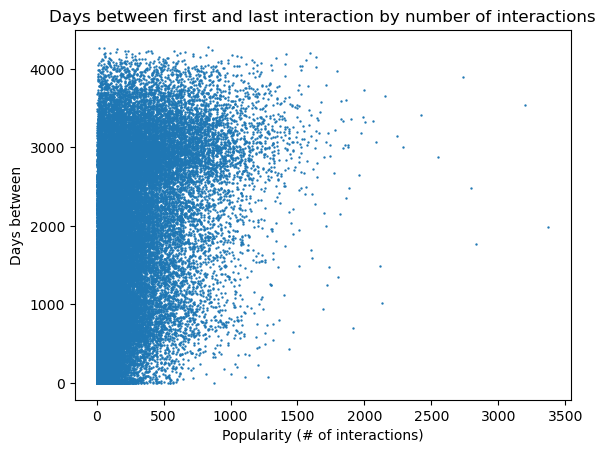

In [321]:
plt.scatter(upops2, uniqs2, s=0.5)
plt.title('Days between first and last interaction by number of interactions')
plt.xlabel('Popularity (# of interactions)')
plt.ylabel('Days between')

In [324]:
temp = np.array(uniqs2)
print(len(temp[temp < 7])/len(temp))

0.07206976876313846


In [ ]:
# review, epinion, yelp